## I. Setup & Data Loading

In [36]:
# Install missing packages (run in notebook)
%pip install shap lightgbm sklearn
# Pin SciPy to a version compatible with installed SHAP to avoid ImportError for internal utilities
# Also pin SHAP to a stable release known to work with SciPy 1.10.x
%pip install --upgrade "scipy==1.10.1" "shap==0.41.0" --quiet

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for shap (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [117 lines of output]
      The nvcc binary could not be located in your $PATH. Either  add it to your path, or set $CUDAHOME to enable CUDA
      Error building cuda module: TypeError('cannot unpack non-iterable NoneType object')
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-311\shap
      copying shap\datasets.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\links.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\_explanation.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\_serializable.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\__init__.py -> build\lib.win-amd64-cpython-311\shap
      creating build\lib.win-amd64-cpython-311\shap\explainers
      copying shap\explainers\mimic.py -> build\lib.win-amd64-cpython-311\shap\explainers

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from datetime import datetime
import joblib
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
import warnings

# Imports (safe to run even if already imported)
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score
)

# Optional: silence warnings
warnings.filterwarnings("ignore")

In [45]:
# Standard imports used in this cell
import sys
import importlib

# Ensure compatible SciPy and SHAP versions are installed before importing
# (use %pip so the install is executed in the notebook kernel environment)
%pip install --upgrade "scipy==1.10.1" "shap==0.41.0" --quiet

# NOTE:
# After installing or downgrading packages that include compiled extensions (like SciPy/SHAP),
# the Jupyter kernel often needs to be restarted for the new binary packages to be loaded.
# We'll try to import and provide a clear message if a restart is required.

try:
	import scipy
	print(f"SciPy version: {scipy.__version__}")
except Exception as e:
	raise ImportError(
		"SciPy could not be imported after installation. "
		"Please restart the Jupyter kernel (Kernel -> Restart) and re-run the notebook."
	) from e

try:
	import shap
	# reload to ensure notebook picks up the freshly installed package if needed
	importlib.reload(shap)
	print(f"SHAP version: {shap.__version__}")
except Exception as e:
	raise ImportError(
		"Failed to import SHAP. This is commonly caused by a binary mismatch between SHAP and SciPy. "
		"Please restart the Jupyter kernel (Kernel -> Restart) and then re-run this cell/notebook. "
		f"Original error: {e}"
	) from e

  error: subprocess-exited-with-error
  
  × Building wheel for shap (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [117 lines of output]
      The nvcc binary could not be located in your $PATH. Either  add it to your path, or set $CUDAHOME to enable CUDA
      Error building cuda module: TypeError('cannot unpack non-iterable NoneType object')
      running bdist_wheel
      running build
      running build_py
      creating build\lib.win-amd64-cpython-311\shap
      copying shap\datasets.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\links.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\_explanation.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\_serializable.py -> build\lib.win-amd64-cpython-311\shap
      copying shap\__init__.py -> build\lib.win-amd64-cpython-311\shap
      creating build\lib.win-amd64-cpython-311\shap\explainers
      copying shap\explainers\mimic.py -> build\lib.win-amd64-cpython-311\shap\explainers

Note: you may need to restart the kernel to use updated packages.
SciPy version: 1.11.2


ImportError: Failed to import SHAP. This is commonly caused by a binary mismatch between SHAP and SciPy. Please restart the Jupyter kernel (Kernel -> Restart) and then re-run this cell/notebook. Original error: cannot import name '_transition_to_rng' from 'scipy._lib._util' (C:\Users\VTC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\_lib\_util.py)

In [ ]:
# Load data
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = BASE_DIR / "converted_data/processed"
MODEL_DIR = BASE_DIR / "models"
PRED_DIR = BASE_DIR / "predictions"

# Create directories
MODEL_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR.mkdir(parents=True, exist_ok=True)

# Load pipeline corrosion data
df = pd.read_csv(DATA_DIR / "market_pipe_thickness_loss_dataset_clean.csv")

print(f" Dataset loaded: {df.shape}")
print(f"   Rows: {len(df):,}")
print(f"   Columns: {len(df.columns)}")

📊 Dataset loaded: (1000, 11)
   Rows: 1,000
   Columns: 11


## II. Feature Engineering

### 2.1 Domain-Specific Features

In [ ]:
# Create feature engineering copy
df_feat = df.copy()

print(" Engineering domain-specific features...\n")

# 1. Corrosion Rate (mm/year)
if 'thickness_loss_mm' in df_feat.columns and 'time_years' in df_feat.columns:
    df_feat['corrosion_rate_mm_year'] = df_feat['thickness_loss_mm'] / (df_feat['time_years'] + 0.01)  # Avoid div by zero
    print(" corrosion_rate_mm_year: Mean = {:.3f}".format(df_feat['corrosion_rate_mm_year'].mean()))

# 2. Remaining Thickness
if 'thickness_mm' in df_feat.columns and 'thickness_loss_mm' in df_feat.columns:
    df_feat['remaining_thickness_mm'] = df_feat['thickness_mm'] - df_feat['thickness_loss_mm']
    print(" remaining_thickness_mm: Mean = {:.3f}".format(df_feat['remaining_thickness_mm'].mean()))

# 3. Safety Margin (%)
if 'remaining_thickness_mm' in df_feat.columns and 'thickness_mm' in df_feat.columns:
    df_feat['safety_margin_percent'] = (df_feat['remaining_thickness_mm'] / df_feat['thickness_mm']) * 100
    print(" safety_margin_percent: Mean = {:.1f}%".format(df_feat['safety_margin_percent'].mean()))

# 4. Remaining Life (years) - Estimate
MINIMUM_SAFE_THICKNESS = 3.0  # mm (domain assumption)
if 'remaining_thickness_mm' in df_feat.columns and 'corrosion_rate_mm_year' in df_feat.columns:
    df_feat['remaining_life_years'] = np.maximum(
        (df_feat['remaining_thickness_mm'] - MINIMUM_SAFE_THICKNESS) / (df_feat['corrosion_rate_mm_year'] + 0.01),
        0
    )
    print(" remaining_life_years: Mean = {:.1f} years".format(df_feat['remaining_life_years'].mean()))

# 5. Risk Score (composite 0-100)
if all(col in df_feat.columns for col in ['material_loss_percent', 'max_pressure_psi', 'time_years']):
    # Normalize components
    material_loss_norm = df_feat['material_loss_percent'] / 100
    pressure_norm = df_feat['max_pressure_psi'] / df_feat['max_pressure_psi'].max()
    time_norm = df_feat['time_years'] / df_feat['time_years'].max()
    
    # Weighted risk score (weights: material=40%, pressure=30%, time=30%)
    df_feat['risk_score'] = (
        0.4 * material_loss_norm * 100 +
        0.3 * pressure_norm * 100 +
        0.3 * time_norm * 100
    )
    print(" risk_score: Mean = {:.1f}".format(df_feat['risk_score'].mean()))

# 6. Pressure-to-Thickness Ratio
if 'max_pressure_psi' in df_feat.columns and 'remaining_thickness_mm' in df_feat.columns:
    df_feat['pressure_thickness_ratio'] = df_feat['max_pressure_psi'] / (df_feat['remaining_thickness_mm'] + 0.1)
    print(" pressure_thickness_ratio: Mean = {:.2f}".format(df_feat['pressure_thickness_ratio'].mean()))

# 7. Age Severity (time × corrosion_rate)
if 'time_years' in df_feat.columns and 'corrosion_rate_mm_year' in df_feat.columns:
    df_feat['age_severity'] = df_feat['time_years'] * df_feat['corrosion_rate_mm_year']
    print(" age_severity: Mean = {:.3f}".format(df_feat['age_severity'].mean()))

print(f"\n Feature engineering complete! New shape: {df_feat.shape}")

🔧 Engineering domain-specific features...

✅ corrosion_rate_mm_year: Mean = 0.753
✅ remaining_thickness_mm: Mean = 11.187
✅ safety_margin_percent: Mean = 53.3%
✅ remaining_life_years: Mean = 62.6 years
✅ risk_score: Mean = 46.3
✅ pressure_thickness_ratio: Mean = 380.25
✅ age_severity: Mean = 4.879

✅ Feature engineering complete! New shape: (1000, 18)


### 2.2 Feature Selection

In [ ]:
# Select features for modeling
target_col = 'condition'

# Exclude ID columns and target
exclude_cols = ['condition', 'pipeline_id', 'segment_id', 'location_id']
feature_cols = [col for col in df_feat.columns if col not in exclude_cols]

# Separate numerical and categorical
numerical_features = df_feat[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_feat[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f" Feature Summary:")
print(f"   Total features: {len(feature_cols)}")
print(f"   Numerical: {len(numerical_features)}")
print(f"   Categorical: {len(categorical_features)}")
print(f"\n   Selected features:")
for feat in feature_cols[:15]:  # Show first 15
    print(f"   - {feat}")
if len(feature_cols) > 15:
    print(f"   ... and {len(feature_cols) - 15} more")

📊 Feature Summary:
   Total features: 17
   Numerical: 15
   Categorical: 2

   Selected features:
   - pipe_size_mm
   - thickness_mm
   - material
   - grade
   - max_pressure_psi
   - temperature_c
   - corrosion_impact_percent
   - thickness_loss_mm
   - material_loss_percent
   - time_years
   - corrosion_rate_mm_year
   - remaining_thickness_mm
   - safety_margin_percent
   - remaining_life_years
   - risk_score
   ... and 2 more


## III. Data Preprocessing

### 3.1 Encoding Categorical Variables

In [ ]:
# Prepare data for modeling
df_model = df_feat[feature_cols + [target_col]].copy()

# Handle missing values
print(" Preprocessing data...\n")
print(f"Missing values before: {df_model.isnull().sum().sum()}")

# Fill numerical missing with median
for col in numerical_features:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].median(), inplace=True)

# Fill categorical missing with mode
for col in categorical_features:
    if df_model[col].isnull().sum() > 0:
        df_model[col].fillna(df_model[col].mode()[0], inplace=True)

print(f"Missing values after: {df_model.isnull().sum().sum()}")

# Label encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col].astype(str))
    label_encoders[col] = le
    print(f"   Encoded {col}: {len(le.classes_)} classes")

# Encode target
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df_model[target_col])
print(f"\n Target encoded: {target_encoder.classes_}")

# Feature matrix
X = df_model.drop(columns=[target_col])
print(f"\n Final dataset: X={X.shape}, y={y.shape}")

🔧 Preprocessing data...

Missing values before: 0
Missing values after: 0
   Encoded material: 5 classes
   Encoded grade: 5 classes

✅ Target encoded: ['Critical' 'Moderate' 'Normal']

✅ Final dataset: X=(1000, 17), y=(1000,)


### 3.2 Train-Test Split

In [ ]:
# Split data (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(" Data Split:")
print(f"   Training set: {X_train.shape}")
print(f"   Test set: {X_test.shape}")
print(f"\n   Class distribution (train):")
train_dist = pd.Series(y_train).value_counts()
for cls, count in train_dist.items():
    print(f"      {target_encoder.classes_[cls]}: {count} ({count/len(y_train)*100:.1f}%)")

print(f"\n   Class distribution (test):")
test_dist = pd.Series(y_test).value_counts()
for cls, count in test_dist.items():
    print(f"      {target_encoder.classes_[cls]}: {count} ({count/len(y_test)*100:.1f}%)")

📊 Data Split:
   Training set: (800, 17)
   Test set: (200, 17)

   Class distribution (train):
      Critical: 390 (48.8%)
      Moderate: 239 (29.9%)
      Normal: 171 (21.4%)

   Class distribution (test):
      Critical: 97 (48.5%)
      Moderate: 60 (30.0%)
      Normal: 43 (21.5%)


### 3.3 Feature Scaling (Optional for Tree Models)

In [ ]:
# Note: Tree-based models (LightGBM, XGBoost) don't require scaling
# But we'll create a scaler for potential future use

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Scaler fitted (saved for future use)")
print(f"   Feature means: {scaler.mean_[:5]} ...")
print(f"   Feature stds: {scaler.scale_[:5]} ...")

✅ Scaler fitted (saved for future use)
   Feature means: [ 519.4375      16.0303375    1.955        2.09375   1004.625    ] ...
   Feature stds: [440.7100051   10.50835572   1.4179122    1.43351349 803.07447312] ...

   Feature means: [ 519.4375      16.0303375    1.955        2.09375   1004.625    ] ...
   Feature stds: [440.7100051   10.50835572   1.4179122    1.43351349 803.07447312] ...


## IV. Model Training

### 4.1 LightGBM Classifier

In [ ]:
print(" Training LightGBM Classifier...\n")

# Define model parameters
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(target_encoder.classes_),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 7,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'random_state': 42
}

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Train model
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_test],
    valid_names=['train', 'test'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)

print(f"\n LightGBM training complete!")
print(f"   Best iteration: {lgb_model.best_iteration}")
print(f"   Best score: {lgb_model.best_score['test']['multi_logloss']:.4f}")

🚀 Training LightGBM Classifier...

Training until validation scores don't improve for 50 rounds
[50]	train's multi_logloss: 0.0312026	test's multi_logloss: 0.0375275
[100]	train's multi_logloss: 0.00229014	test's multi_logloss: 0.0126719
Early stopping, best iteration is:
[90]	train's multi_logloss: 0.00355323	test's multi_logloss: 0.0117771

✅ LightGBM training complete!
   Best iteration: 90
   Best score: 0.0118
[50]	train's multi_logloss: 0.0312026	test's multi_logloss: 0.0375275
[100]	train's multi_logloss: 0.00229014	test's multi_logloss: 0.0126719
Early stopping, best iteration is:
[90]	train's multi_logloss: 0.00355323	test's multi_logloss: 0.0117771

✅ LightGBM training complete!
   Best iteration: 90
   Best score: 0.0118


### 4.2 Predictions

In [ ]:
# Make predictions
y_pred_proba = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
y_pred = np.argmax(y_pred_proba, axis=1)

print(" Predictions generated")
print(f"   Prediction shape: {y_pred.shape}")
print(f"   Probability shape: {y_pred_proba.shape}")

✅ Predictions generated
   Prediction shape: (200,)
   Probability shape: (200, 3)


## V. Model Evaluation

### 5.1 Classification Metrics

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("="*70)
print(" "*20 + "MODEL PERFORMANCE")
print("="*70)
print(f"\n Overall Metrics:")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   F1-Score (Macro): {f1_macro:.4f}")
print(f"   F1-Score (Weighted): {f1_weighted:.4f}")

# Classification report
print(f"\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

                    MODEL PERFORMANCE

📊 Overall Metrics:
   Accuracy: 0.9950 (99.50%)
   F1-Score (Macro): 0.9933
   F1-Score (Weighted): 0.9950

📋 Classification Report:
              precision    recall  f1-score   support

    Critical       1.00      1.00      1.00        97
    Moderate       0.98      1.00      0.99        60
      Normal       1.00      0.98      0.99        43

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       1.00      0.99      0.99       200



### 5.2 Confusion Matrix

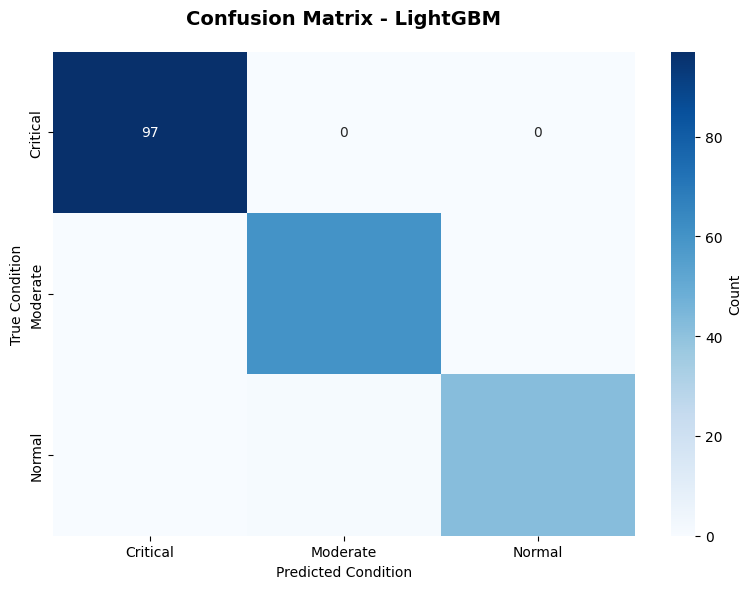


✅ Per-Class Accuracy:
   Critical: 1.0000 (100.00%)
   Moderate: 1.0000 (100.00%)
   Normal: 0.9767 (97.67%)


In [39]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - LightGBM', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Condition')
plt.ylabel('True Condition')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
print("\n✅ Per-Class Accuracy:")
for i, cls in enumerate(target_encoder.classes_):
    class_acc = cm[i, i] / cm[i, :].sum()
    print(f"   {cls}: {class_acc:.4f} ({class_acc*100:.2f}%)")

### 5.3 ROC-AUC Curves

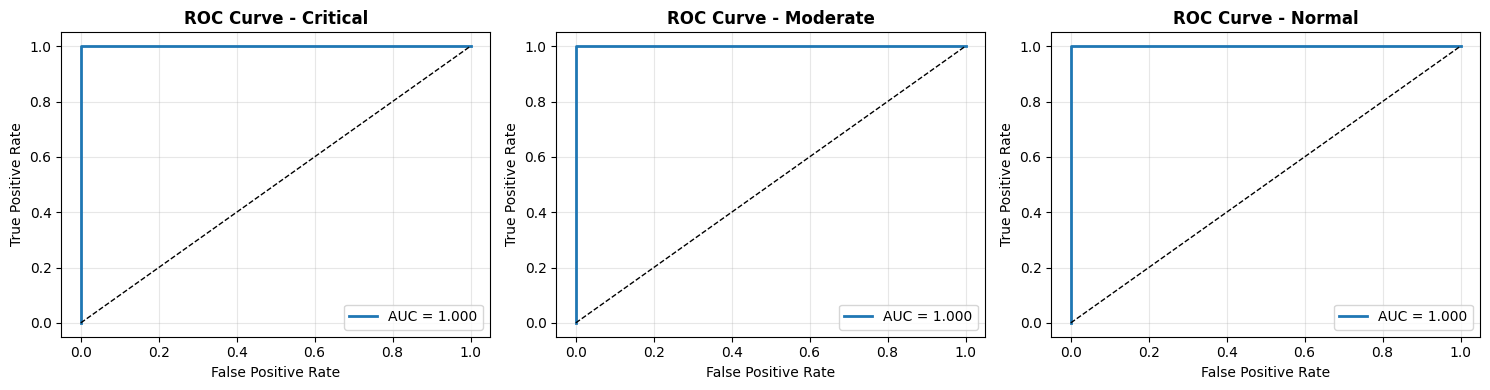


📊 Overall ROC-AUC (Macro): 1.0000


In [40]:
# Calculate ROC-AUC for each class (One-vs-Rest)
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.arange(len(target_encoder.classes_)))
n_classes = y_test_bin.shape[1]

# Plot ROC curves
fig, axes = plt.subplots(1, n_classes, figsize=(15, 4))
if n_classes == 1:
    axes = [axes]

for i, cls in enumerate(target_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
    
    axes[i].plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}', linewidth=2)
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve - {cls}', fontweight='bold')
    axes[i].legend(loc='lower right')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Overall ROC-AUC
roc_auc_macro = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
print(f"\n📊 Overall ROC-AUC (Macro): {roc_auc_macro:.4f}")

## VI. Feature Importance Analysis

### 6.1 Built-in Feature Importance

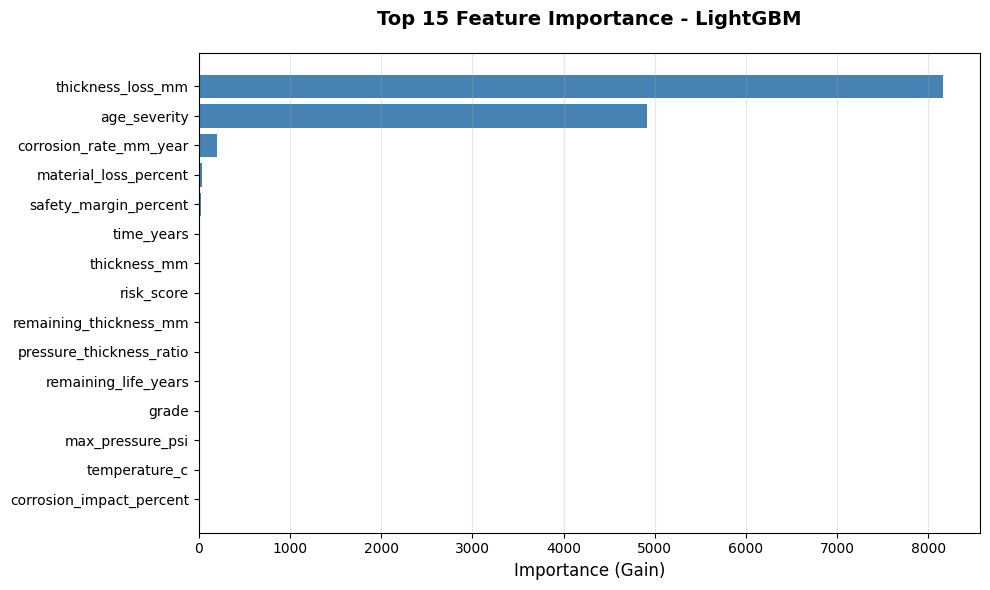


📊 Top 15 Most Important Features:


,feature,importance
7,thickness_loss_mm,8157.322622
16,age_severity,4915.041801
10,corrosion_rate_mm_year,201.679171
8,material_loss_percent,39.011276
12,safety_margin_percent,18.430821
9,time_years,14.968502
1,thickness_mm,8.975542
14,risk_score,7.979859
11,remaining_thickness_mm,3.280460
15,pressure_thickness_ratio,2.099069


In [ ]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Plot top 15 features
top_n = 15
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:top_n][::-1], 
         feature_importance['importance'][:top_n][::-1],
         color='steelblue')
plt.xlabel('Importance (Gain)', fontsize=12)
plt.title(f'Top {top_n} Feature Importance - LightGBM', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n Top {top_n} Most Important Features:")
display(feature_importance.head(top_n))

### 6.2 SHAP Analysis

In [ ]:
print(" Running SHAP analysis (this may take a few minutes)...\n")

# Create SHAP explainer
explainer = shap.TreeExplainer(lgb_model)

# Calculate SHAP values (use subset for speed)
sample_size = min(500, len(X_test))
X_test_sample = X_test.iloc[:sample_size]
shap_values = explainer.shap_values(X_test_sample)

print(f" SHAP values calculated for {sample_size} samples")

🔍 Running SHAP analysis (this may take a few minutes)...



NameError: name 'shap' is not defined

In [ ]:
# SHAP Summary Plot (for each class)
for i, cls in enumerate(target_encoder.classes_):
    print(f"\n SHAP Summary - Class: {cls}")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values[i], X_test_sample, plot_type="bar", show=False)
    plt.title(f'SHAP Feature Importance - {cls}', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

In [ ]:
# SHAP Beeswarm Plot (shows feature value impact)
print("\n SHAP Beeswarm Plot (Critical class):\n")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values[0], X_test_sample, show=False)  # Critical class = index 0
plt.title('SHAP Feature Impact - Critical Condition', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## VII. Forecasting & Predictions

### 7.1 Remaining Useful Life (RUL) Predictions

In [ ]:
# Generate predictions for full dataset
full_pred_proba = lgb_model.predict(X, num_iteration=lgb_model.best_iteration)
full_pred = np.argmax(full_pred_proba, axis=1)
full_pred_labels = target_encoder.inverse_transform(full_pred)

# Create predictions dataframe
predictions_df = df_feat.copy()
predictions_df['predicted_condition'] = full_pred_labels
predictions_df['pred_critical_prob'] = full_pred_proba[:, 0]  # Probability of Critical
predictions_df['pred_moderate_prob'] = full_pred_proba[:, 1]  # Probability of Moderate
predictions_df['pred_normal_prob'] = full_pred_proba[:, 2]  # Probability of Normal

# Calculate confidence score (max probability)
predictions_df['confidence_score'] = np.max(full_pred_proba, axis=1)

# Maintenance priority (1=urgent, 2=soon, 3=scheduled, 4=routine)
def assign_priority(row):
    if row['predicted_condition'] == 'Critical':
        return 1 if row['remaining_life_years'] < 1 else 2
    elif row['predicted_condition'] == 'Moderate':
        return 2 if row['remaining_life_years'] < 3 else 3
    else:
        return 3 if row['remaining_life_years'] < 5 else 4

predictions_df['maintenance_priority'] = predictions_df.apply(assign_priority, axis=1)

print(" Predictions generated for all pipelines\n")
print(f" Prediction Summary:")
print(predictions_df['predicted_condition'].value_counts())
print(f"\n Maintenance Priority Distribution:")
priority_map = {1: 'Urgent', 2: 'Soon', 3: 'Scheduled', 4: 'Routine'}
for priority, count in predictions_df['maintenance_priority'].value_counts().sort_index().items():
    print(f"   {priority_map[priority]}: {count} ({count/len(predictions_df)*100:.1f}%)")

### 7.2 Critical Pipelines Report

In [ ]:
# Identify critical pipelines requiring immediate attention
critical_pipelines = predictions_df[
    (predictions_df['predicted_condition'] == 'Critical') |
    (predictions_df['maintenance_priority'] == 1)
].sort_values(['maintenance_priority', 'remaining_life_years'])

print(" CRITICAL PIPELINES REQUIRING IMMEDIATE ATTENTION:\n")
print(f"   Total critical: {len(critical_pipelines)}")

if len(critical_pipelines) > 0:
    display_cols = [
        'pipeline_id', 'segment_id', 'predicted_condition', 'confidence_score',
        'remaining_life_years', 'risk_score', 'corrosion_rate_mm_year',
        'safety_margin_percent', 'maintenance_priority'
    ]
    available_display = [col for col in display_cols if col in critical_pipelines.columns]
    
    print("\n   Top 10 most critical:")
    display(critical_pipelines[available_display].head(10))
else:
    print("  No critical pipelines detected!")

## VIII. Model & Predictions Export

### 8.1 Save Model

In [ ]:
# Save LightGBM model
model_filename = MODEL_DIR / f"lgb_corrosion_model_{datetime.now().strftime('%Y%m%d')}.txt"
lgb_model.save_model(str(model_filename))
print(f" Model saved: {model_filename}")

# Save encoders and scaler
artifacts = {
    'target_encoder': target_encoder,
    'label_encoders': label_encoders,
    'scaler': scaler,
    'feature_names': X.columns.tolist()
}
artifacts_filename = MODEL_DIR / f"model_artifacts_{datetime.now().strftime('%Y%m%d')}.pkl"
joblib.dump(artifacts, artifacts_filename)
print(f" Artifacts saved: {artifacts_filename}")

### 8.2 Save Predictions

In [ ]:
# Save full predictions
pred_filename = PRED_DIR / f"corrosion_predictions_{datetime.now().strftime('%Y%m%d')}.csv"
predictions_df.to_csv(pred_filename, index=False)
print(f" Predictions saved: {pred_filename}")

# Save critical pipelines report
critical_filename = PRED_DIR / f"critical_pipelines_{datetime.now().strftime('%Y%m%d')}.csv"
critical_pipelines.to_csv(critical_filename, index=False)
print(f" Critical report saved: {critical_filename}")

## IX. Summary & Next Steps

In [ ]:
print("="*70)
print(" "*20 + "MODELING SUMMARY")
print("="*70)

print("\n Model Performance:")
print(f"   Algorithm: LightGBM Gradient Boosting")
print(f"   Accuracy: {accuracy*100:.2f}%")
print(f"   F1-Score (Macro): {f1_macro:.4f}")
print(f"   ROC-AUC (Macro): {roc_auc_macro:.4f}")
print(f"   Best Iteration: {lgb_model.best_iteration}")

print("\n Feature Engineering:")
print(f"   Total features: {len(X.columns)}")
print(f"   Engineered features: corrosion_rate, remaining_life, risk_score, etc.")
print(f"   Top feature: {feature_importance.iloc[0]['feature']}")

print("\n Critical Insights:")
print(f"   Critical pipelines: {len(critical_pipelines)}")
print(f"   Urgent maintenance: {(predictions_df['maintenance_priority']==1).sum()}")
print(f"   Mean RUL: {predictions_df['remaining_life_years'].mean():.1f} years")

print("\n Outputs:")
print(f"   Model: {model_filename.name}")
print(f"   Predictions: {pred_filename.name}")
print(f"   Critical Report: {critical_filename.name}")

print("\n Next Steps:")
print("   1. Integrate predictions into dashboard (Streamlit/PowerBI)")
print("   2. Set up automated retraining pipeline")
print("   3. Implement real-time monitoring alerts")
print("   4. Validate predictions with domain experts")
print("   5. Deploy model as API endpoint (FastAPI/Flask)")

print("\n" + "="*70)
print(" MODELING COMPLETE")
print("="*70)